In [ ]:
import pandas  as pd
import seaborn as sns
from sklearn.discriminant_analysis import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import os
from utils import run_kfold_eval, calculate_metric
import optuna
import time
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
import joblib
from pathlib import Path

In [33]:
DATA_FOLDER = "../data"
TRAIN_FEATURES = DATA_FOLDER + '/train_features2.xlsx'
TRAIN_LABELS = DATA_FOLDER + "/train_labels2.xlsx"
TEST_FEATURES = DATA_FOLDER + "/test_features2.xlsx"
TEST_LABELS = DATA_FOLDER + "/test_labels2.xlsx"
OUTPUT_PATH = '../output/lasso'

In [ ]:
# create path
output_dir = Path(OUTPUT_PATH)
output_dir.mkdir(parents=True, exist_ok=True)

In [14]:
train_features = pd.read_excel(TRAIN_FEATURES)
train_labels = pd.read_excel(TRAIN_LABELS)
test_features = pd.read_excel(TEST_FEATURES)
test_labels = pd.read_excel(TEST_LABELS)

In [15]:
test_features.head()

,coupon rate,SP500 MD,Average daily 1-year SP500 return,Ratio to MA,US Corporate Bond Yield Spread,US Corporate Bond Yield Spread(3-5 year),US Corporate Bond Yield Spread(5-7 year),US Corporate Bond Yield Spread(7-10 year),US Corporate Bond Yield Spread(10+ year),US Generic Govt 3 Month Yield,...,event_type_subcategory_sum_Missing Coupon payment only,event_type_subcategory_sum_Missing Interest payment,event_type_subcategory_sum_Missing Loan payment,event_type_subcategory_sum_Missing Principal payment,event_type_subcategory_sum_Others,event_type_subcategory_sum_Pre-Negotiated Chapter 11,event_type_subcategory_sum_Protection,event_type_subcategory_sum_Receivership,event_type_subcategory_sum_Rehabilitation,event_type_subcategory_sum_Restructuring
0,3.125,-122.39680,-0.001341,1.116103,396.408936,399.031738,455.0625,383.612488,341.675812,0.1734,...,False,False,False,False,False,False,False,False,False,False
1,15.000,156.01912,0.000790,6.372588,107.083778,76.414360,118.2482,113.403519,147.756165,0.0253,...,False,False,False,False,False,False,False,False,False,False
2,0.000,-451.10824,-0.002033,43.914617,637.607544,689.770996,683.3611,589.969666,529.166992,0.0406,...,False,False,False,True,False,False,False,False,False,False
3,5.875,-751.22120,-0.000435,74.783398,153.653778,129.425842,158.3252,172.708054,187.147980,1.4908,...,False,False,False,False,False,False,False,False,False,False
4,10.000,55.69036,0.000712,-28.522133,152.290619,148.385330,222.1811,142.140915,159.624313,0.0763,...,False,False,False,False,False,False,False,False,False,False


In [16]:
print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
print(test_labels.shape)

(1293, 317)
(1293, 1)
(432, 317)
(432, 1)


In [49]:
feature_list = train_features.columns
# category_feature_key = ['currency', 'seniorioty_adj', 'domicile_country',	'exchange_country',	'Industry_sector',	'Industry_group',	'Industry_subgroup', 'event_type',
#                  'event_type_subcategory_sum', 'defaulted_in_last_6_months']
# category_features = [i for i in feature_list if any(sub in i for sub in category_feature_key)]
category_features = train_features.select_dtypes(include=['int', 'bool']).columns
non_category_features = [i for i in feature_list if i not in category_features]

print(len(category_features))
print(len(non_category_features))

164
153


In [51]:
category_features

Index(['defaulted_in_last_5_years', 'defaulted_in_last_6_months',
       'currency_CAD', 'currency_CHF', 'currency_CNY', 'currency_EUR',
       'currency_GBP', 'currency_HKD', 'currency_INR', 'currency_ISK',
       ...
       'event_type_subcategory_sum_Missing Coupon payment only',
       'event_type_subcategory_sum_Missing Interest payment',
       'event_type_subcategory_sum_Missing Loan payment',
       'event_type_subcategory_sum_Missing Principal payment',
       'event_type_subcategory_sum_Others',
       'event_type_subcategory_sum_Pre-Negotiated Chapter 11',
       'event_type_subcategory_sum_Protection',
       'event_type_subcategory_sum_Receivership',
       'event_type_subcategory_sum_Rehabilitation',
       'event_type_subcategory_sum_Restructuring'],
      dtype='object', length=164)

In [19]:
# Normalize the data
# Prepare the ColumnTransformer

scaler = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), non_category_features)   # StandardScaler()
    ],
    remainder='passthrough'  # Leave categorical features untouched
)

In [52]:
def objective(trial):

    alpha = trial.suggest_float('alpha', 1e-5, 10.0, log=True)
    
    # Create the pipeline with the current hyperparameters
    pipeline = Pipeline([
        ('scaler', scaler),
        ('lasso', Lasso(alpha=alpha, random_state=42))
    ])
    
    score = cross_val_score(pipeline, train_features, train_labels['rr1_30'].to_numpy(), cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
    return score

In [53]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-03-31 10:42:48,024] A new study created in memory with name: no-name-162e5065-fcaf-432c-8de1-0aa7d57ed413


  0%|          | 0/100 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.214e-02, tolerance: 1.128e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.262e-02, tolerance: 1.111e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-03-31 10:42:58,070] Trial 0 finished with value: -0.10109264408862455 and parameters: {'alpha': 0.0003611785292576564}. Best is trial 0 with value: -0.10109264408862455.
[I 2025-03-31 10:43:00,525] Trial 1 finished with value: -0.1085148053872298 and parameters: {'alpha': 3.364587208746634}. Best is trial 0 with value: -0.10109264408862455.
[I 2025-03-31 10:43:01,537] Trial 2 finished with value: -0.08894834438097213 and parameters: {'alpha': 0.039172540274291436}. Best is trial 2 with value: -0.08894834438097213.
[I 2025-03-31 10:43:01,751] Trial 3 finished with value: -0.1085148053872298 and parameters: {'alpha': 0.756376443071916}. Best is trial 2 with value: -0.08894834438097213.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.022e-01, tolerance: 1.128e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.645e-02, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-03-31 10:43:03,368] Trial 4 finished with value: -0.10516230424317141 and parameters: {'alpha': 0.0004186960972751081}. Best is trial 2 with value: -0.08894834438097213.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.330e+01, tolerance: 1.128e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.137e+01, tolerance: 1.122e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-03-31 10:43:05,128] Trial 5 finished with value: -0.11142407496241213 and parameters: {'alpha': 4.125848604722561e-05}. Best is trial 2 with value: -0.08894834438097213.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.186e-02, tolerance: 1.128e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.282e-01, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-03-31 10:43:06,428] Trial 6 finished with value: -0.09492640501163971 and parameters: {'alpha': 0.0003148120299523085}. Best is trial 2 with value: -0.08894834438097213.
[I 2025-03-31 10:43:07,350] Trial 7 finished with value: -0.07859585503835038 and parameters: {'alpha': 0.016907636861173348}. Best is trial 7 with value: -0.07859585503835038.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.182e+01, tolerance: 1.122e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.360e+01, tolerance: 1.128e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-03-31 10:43:08,362] Trial 8 finished with value: -0.11163463311795156 and parameters: {'alpha': 3.956607790946771e-05}. Best is trial 7 with value: -0.07859585503835038.
[I 2025-03-31 10:43:09,010] Trial 9 finished with value: -0.07963172637890734 and parameters: {'alpha': 0.0013534143807024778}. Best is trial 7 with value: -0.07859585503835038.
[I 2025-03-31 10:43:09,580] Trial 10 finished with value: -0.08950479937183436 and parameters: {'alpha': 0.04039328237938866}. Best is trial 7 with value: -0.07859585503835038.
[I 2025-03-31 10:43:10,445] Trial 11 finished with value: -0.0762445979468829 and parameters: {'alpha': 0.006577662698462049}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:11,415] Trial 12 finished with value: -0.0762611094969968 and parameters: {'alpha': 0.0068067792727838595}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:11,599] Trial 13 finished with value: -0.1085148053872298 and parameters: {'alpha': 0.257888

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.799e+01, tolerance: 1.122e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.082e+01, tolerance: 1.103e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-03-31 10:43:15,855] Trial 20 finished with value: -0.11420066860933213 and parameters: {'alpha': 1.595253842121703e-05}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:16,531] Trial 21 finished with value: -0.0765190283848099 and parameters: {'alpha': 0.005038555909519759}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:17,198] Trial 22 finished with value: -0.07706443901666002 and parameters: {'alpha': 0.011268219911077695}. Best is trial 11 with value: -0.0762445979468829.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.926e-02, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(


[I 2025-03-31 10:43:18,015] Trial 23 finished with value: -0.08578279293917805 and parameters: {'alpha': 0.0009734615139095962}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:18,552] Trial 24 finished with value: -0.07752821317532299 and parameters: {'alpha': 0.013374811387454605}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:19,466] Trial 25 finished with value: -0.07836847229609958 and parameters: {'alpha': 0.0015424342130056137}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:19,646] Trial 26 finished with value: -0.1084721699369611 and parameters: {'alpha': 0.11696700472367112}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:19,806] Trial 27 finished with value: -0.1085148053872298 and parameters: {'alpha': 0.47547708508008535}. Best is trial 11 with value: -0.0762445979468829.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.909e+00, tolerance: 1.103e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.396e-01, tolerance: 1.128e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-03-31 10:43:20,867] Trial 28 finished with value: -0.09748622494483744 and parameters: {'alpha': 0.00013712436124107505}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:21,441] Trial 29 finished with value: -0.08093469595241806 and parameters: {'alpha': 0.022263529224545248}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:22,338] Trial 30 finished with value: -0.07629741242994308 and parameters: {'alpha': 0.007125414163548396}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:23,020] Trial 31 finished with value: -0.07628553054383677 and parameters: {'alpha': 0.007046421256185432}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:23,824] Trial 32 finished with value: -0.07625127040632142 and parameters: {'alpha': 0.00627939129118105}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:24,566] Trial 33 finished with value: -0.0768382901712312 and parameters: {'alpha': 0.002

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.359e-02, tolerance: 1.128e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.386e-02, tolerance: 1.111e-02
  model = cd_fast.enet_coordinate_descent(


[I 2025-03-31 10:43:25,281] Trial 34 finished with value: -0.0998738125503642 and parameters: {'alpha': 0.0005903516054768371}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:25,709] Trial 35 finished with value: -0.08424422478836761 and parameters: {'alpha': 0.029264611520818523}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:26,320] Trial 36 finished with value: -0.07653187418601051 and parameters: {'alpha': 0.004968199458898818}. Best is trial 11 with value: -0.0762445979468829.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.735e-01, tolerance: 1.111e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.939e-01, tolerance: 1.128e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-03-31 10:43:27,142] Trial 37 finished with value: -0.09137312038136758 and parameters: {'alpha': 0.00020359030776964256}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:27,770] Trial 38 finished with value: -0.09347925665661079 and parameters: {'alpha': 0.0007493373674022013}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:27,943] Trial 39 finished with value: -0.104441580633948 and parameters: {'alpha': 0.09027288929024005}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:28,335] Trial 40 finished with value: -0.09341069674866738 and parameters: {'alpha': 0.049440830224667595}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:28,857] Trial 41 finished with value: -0.07625778726978126 and parameters: {'alpha': 0.006755034034043299}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:29,516] Trial 42 finished with value: -0.07887373713859654 and parameters: {'alpha': 0.017

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e-01, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.064e-01, tolerance: 1.111e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-03-31 10:43:39,445] Trial 50 finished with value: -0.0976725762227945 and parameters: {'alpha': 0.00033650105098110845}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:40,870] Trial 51 finished with value: -0.07630031569331311 and parameters: {'alpha': 0.007144295696633252}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:41,953] Trial 52 finished with value: -0.07687605194675637 and parameters: {'alpha': 0.0021647852305527442}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:44,050] Trial 53 finished with value: -0.07636401944342705 and parameters: {'alpha': 0.008741175152395298}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:45,606] Trial 54 finished with value: -0.07667111690669606 and parameters: {'alpha': 0.0037658109835854744}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:43:46,711] Trial 55 finished with value: -0.0935451914893902 and parameters: {'alpha': 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.769e-02, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(


[I 2025-03-31 10:44:04,050] Trial 66 finished with value: -0.08733021082196167 and parameters: {'alpha': 0.0009186724234751961}. Best is trial 11 with value: -0.0762445979468829.
[I 2025-03-31 10:44:05,706] Trial 67 finished with value: -0.07624285298424693 and parameters: {'alpha': 0.006409945509363393}. Best is trial 67 with value: -0.07624285298424693.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.333e-02, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.734e-02, tolerance: 1.128e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-03-31 10:44:07,823] Trial 68 finished with value: -0.10240783872436192 and parameters: {'alpha': 0.0005132896649496318}. Best is trial 67 with value: -0.07624285298424693.
[I 2025-03-31 10:44:09,660] Trial 69 finished with value: -0.07671219622391598 and parameters: {'alpha': 0.0034506079777182636}. Best is trial 67 with value: -0.07624285298424693.
[I 2025-03-31 10:44:11,116] Trial 70 finished with value: -0.07923791805844618 and parameters: {'alpha': 0.018638668784745932}. Best is trial 67 with value: -0.07624285298424693.
[I 2025-03-31 10:44:13,062] Trial 71 finished with value: -0.07626557917810753 and parameters: {'alpha': 0.006140008553365565}. Best is trial 67 with value: -0.07624285298424693.
[I 2025-03-31 10:44:14,682] Trial 72 finished with value: -0.07631792758784973 and parameters: {'alpha': 0.0058311016043212805}. Best is trial 67 with value: -0.07624285298424693.
[I 2025-03-31 10:44:15,776] Trial 73 finished with value: -0.07679044735909257 and parameters: {'alpha

In [54]:
study.best_params

{'alpha': 0.006409945509363393}

In [55]:
start_time = time.time()

# Get the best hyperparameters
best_params = study.best_params

# Train the final model on the entire training data
pipeline = Pipeline([
        ('scaler', scaler),
        ('lasso', Lasso(random_state=42, **best_params))
    ])

pipeline.fit(train_features, train_labels.to_numpy())

elapsed_time = time.time() - start_time
print(f"Training time: {elapsed_time:.3f} seconds")

# do prediction
predictions = pipeline.predict(test_features)


Training time: 1.373 seconds


In [30]:
start_time = time.time()

# Get the best hyperparameters
best_params = study.best_params

# Train the final model on the entire training data
pipeline = Pipeline([
        ('scaler', scaler),
        ('lasso', Lasso(random_state=42, **best_params))
    ])

pipeline.fit(train_features, train_labels["rr1_30"].to_numpy())

elapsed_time = time.time() - start_time
print(f"Training time: {elapsed_time:.3f} seconds")

# do prediction
predictions = pipeline.predict(test_features)


Training time: 1.365 seconds


In [56]:

# save metrics
mae, mape, rmse, rsqr = calculate_metric(predictions, test_labels['rr1_30'].to_numpy())
print(f"Val average mean absolute error: {mae}")
print(f"Val average mean absolute percentage error: {mape}")
print(f"Val average root mean squared error: {rmse}")
print(f"Val average R2: {rsqr}")

Val average mean absolute error: 0.22579905758406948
Val average mean absolute percentage error: 389.405334034586
Val average root mean squared error: 0.2754503662851118
Val average R2: 0.33760904972110783


In [57]:
# Save the best model (you could use joblib in a real scenario)
joblib.dump(pipeline, OUTPUT_PATH + '/lasso_model.pkl')

['../output/lasso/lasso_model.pkl']

In [58]:
# Get the model coefficients
coef = pipeline.named_steps['lasso'].coef_

In [62]:
new_feature_list = non_category_features + category_features.to_list()

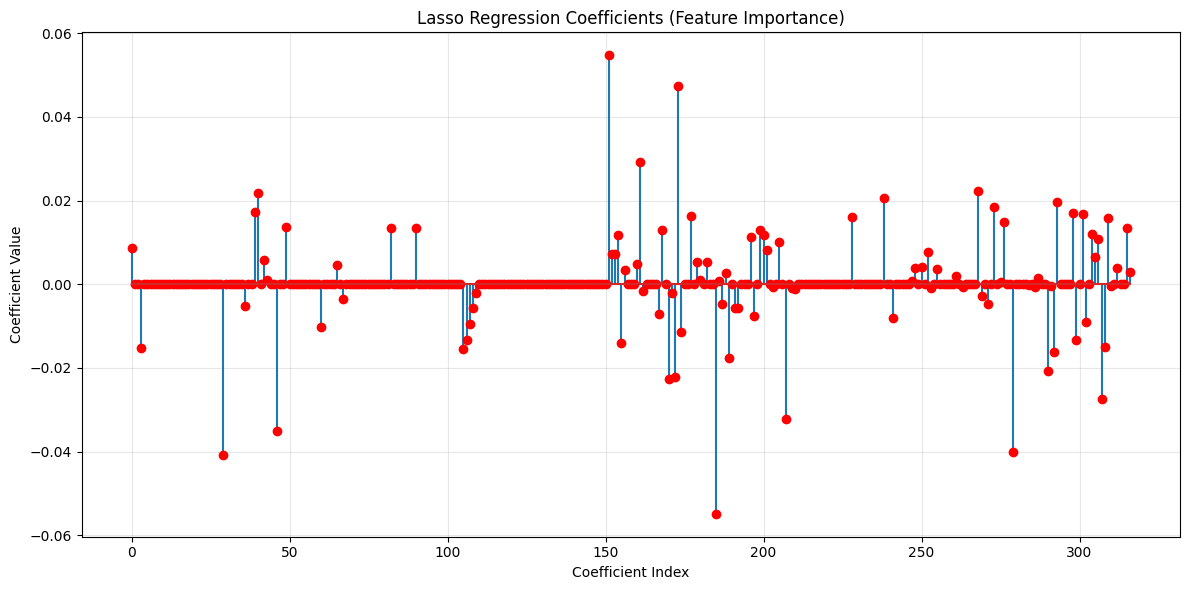

In [75]:
# Plot the coefficients
plt.figure(figsize=(12, 6))
plt.stem(range(len(coef)), coef, markerfmt='ro')
# plt.xticks(range(len(coef)), new_feature_list, rotation=90)
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title('Lasso Regression Coefficients (Feature Importance)')
plt.tight_layout()
plt.grid(True, alpha=0.3)

In [82]:
non_zero_coeff = []
non_zero_features = []
for index, value in enumerate(coef):
    if value == 0:
        continue
    non_zero_coeff.append(value)
    non_zero_features.append(new_feature_list[index])

In [92]:
### Feature importance 

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': non_zero_features,
    'Importance': non_zero_coeff
})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

In [93]:
feature_importances

,Feature,Importance
40,domicile_country_China,-0.054889
2,PD_12_exch_sector,-0.040797
77,Industry_subgroup_Metals & Mining,-0.040035
8,Sigma,-0.035156
54,exchange_country_Hong Kong,-0.032347
...,...,...
5,exch_subsector_dtd,0.021825
71,Industry_subgroup_Health Care Facilities & Svcs,0.022279
27,currency_INR,0.029196
34,seniorioty_adj_Senior Secured,0.047294


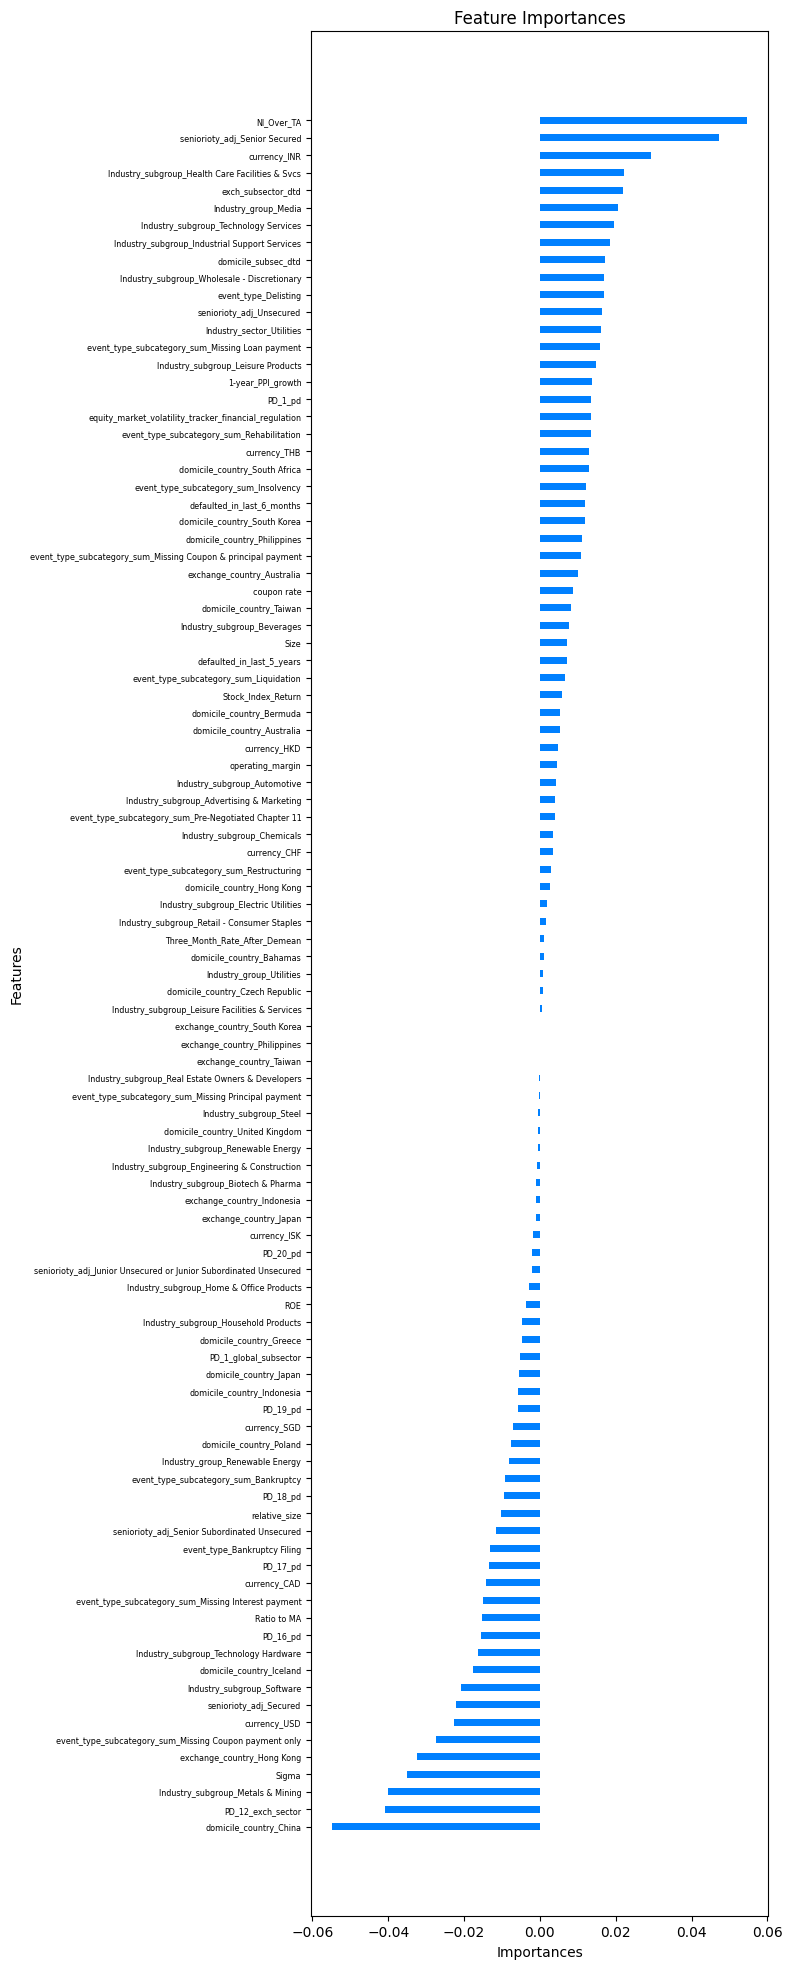

In [103]:
# Create a horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color=(0, 0.5, 1), height=0.4)  # Adjust the height for spacing
# Increase figure height to accommodate the spacing
plt.gcf().set_size_inches(10, max(2, len(feature_importances) * 0.2))

plt.ylabel('Features')  # Label for the y-axis
plt.xlabel('Importances')  # Label for the x-axis
plt.title('Feature Importances')  # Title of the plot
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.yticks(fontsize='xx-small')
plt.savefig(os.path.join(OUTPUT_PATH,'rf_feature_importance.png'))

plt.show()

5-fold CV

In [105]:
features = pd.concat([train_features, test_features], axis=0, ignore_index=True)
features

,coupon rate,SP500 MD,Average daily 1-year SP500 return,Ratio to MA,US Corporate Bond Yield Spread,US Corporate Bond Yield Spread(3-5 year),US Corporate Bond Yield Spread(5-7 year),US Corporate Bond Yield Spread(7-10 year),US Corporate Bond Yield Spread(10+ year),US Generic Govt 3 Month Yield,...,event_type_subcategory_sum_Missing Coupon payment only,event_type_subcategory_sum_Missing Interest payment,event_type_subcategory_sum_Missing Loan payment,event_type_subcategory_sum_Missing Principal payment,event_type_subcategory_sum_Others,event_type_subcategory_sum_Pre-Negotiated Chapter 11,event_type_subcategory_sum_Protection,event_type_subcategory_sum_Receivership,event_type_subcategory_sum_Rehabilitation,event_type_subcategory_sum_Restructuring
0,7.500,-117.46020,-0.000189,125.407139,177.213028,134.012054,198.8153,191.364395,223.346344,0.1983,...,True,False,False,False,False,False,False,False,False,False
1,6.000,166.38276,0.000768,-4.603446,101.613617,77.032829,123.3998,105.932022,139.111115,0.0355,...,False,False,False,False,False,False,False,False,False,False
2,11.000,119.85752,0.000678,-11.950380,104.545959,77.416649,129.4317,111.818001,139.717407,0.0101,...,False,False,False,False,False,False,False,False,False,False
3,9.125,653.51208,0.001638,-2.494861,90.736633,64.654129,95.3731,92.141212,121.666237,0.0152,...,False,False,False,False,False,False,False,False,False,False
4,9.250,231.89472,0.000664,4.823413,98.533821,68.759308,93.4174,107.424469,139.741165,1.2865,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,3.250,147.33344,0.000556,3.538252,128.976395,95.360374,138.8445,138.946106,172.733887,0.0000,...,False,False,False,False,False,False,False,False,False,False
1721,10.000,175.31656,0.000554,-4.067337,121.170998,92.879501,123.2500,131.104904,162.916901,0.7516,...,False,True,False,False,False,False,False,False,False,False
1722,7.450,315.81748,0.000747,8.604100,126.786606,89.018188,114.9728,131.522430,171.701096,0.0864,...,False,False,False,False,False,False,False,False,False,False
1723,0.500,31.75120,-0.000157,-4.373852,126.595230,105.460007,121.6212,147.382416,163.772141,4.8375,...,False,False,False,False,False,False,False,False,False,False


In [106]:
labels = pd.concat([train_labels, test_labels], axis=0, ignore_index=True)
labels

,rr1_30
0,0.082481
1,0.378845
2,0.836149
3,0.987208
4,1.021458
...,...
1720,0.471411
1721,0.823750
1722,0.241612
1723,0.762054


In [107]:
pipeline = Pipeline([
        ('scaler', scaler),
        ('lasso', Lasso(random_state=42, **best_params))
    ])
# pipeline.fit(train_features, train_labels)

In [108]:
train_preds, oof_preds, feat_importances, train_metrics, val_metrics = run_kfold_eval(features, labels.to_numpy(), n_folds=5, model=pipeline, model_params=None, output_path=OUTPUT_PATH, name="xgboost")

100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


In [109]:
# print test resuls
mae = 0
mape = 0
rmse = 0
rsqr = 0
i = 0

for key, value in train_metrics.items():
  if "mae" in key:
    i += 1
    mae += value

  if "mape" in key:
    mape += value

  if "rmse" in key:
    rmse += value

  if "rsqr" in key:
    rsqr += value

print(f"Training average mean absolute error: {mae/i}")
print(f"Training average mean absolute percentage error: {mape/i}")
print(f"Training average root mean squared error: {rmse/i}")
print(f"Training average R2: {rsqr/i}")

Training average mean absolute error: 0.31887597523765127
Training average mean absolute percentage error: 3587.017180835012
Training average root mean squared error: 0.24546254480994284
Training average R2: 0.45204074309692144


In [110]:
# print test resuls
mae = 0
mape = 0
rmse = 0
rsqr = 0
i = 0

for key, value in val_metrics.items():
  if "mae" in key:
    i += 1
    mae += value

  if "mape" in key:
    mape += value

  if "rmse" in key:
    rmse += value

  if "rsqr" in key:
    rsqr += value

print(f"Test average mean absolute error: {mae/i}")
print(f"Test average mean absolute percentage error: {mape/i}")
print(f"Test average root mean squared error: {rmse/i}")
print(f"Test average R2: {rsqr/i}")

Test average mean absolute error: 0.3207963004399647
Test average mean absolute percentage error: 3689.2855343450947
Test average root mean squared error: 0.26950622774099475
Test average R2: 0.3353713124884782


In [ ]:
# print test resuls
mae = 0
mape = 0
rmse = 0
rsqr = 0
i = 0

for key, value in val_metrics.items():
  if "mae" in key:
    i += 1
    mae += value

  if "mape" in key:
    mape += value

  if "rmse" in key:
    rmse += value

  if "rsqr" in key:
    rsqr += value

print(f"Test average mean absolute error: {mae/i}")
print(f"Test average mean absolute percentage error: {mape/i}")
print(f"Test average root mean squared error: {rmse/i}")
print(f"Test average R2: {rsqr/i}")

Test average mean absolute error: 0.3207963004399647
Test average mean absolute percentage error: 3689.2855343450947
Test average root mean squared error: 0.26950622774099475
Test average R2: 0.3353713124884782
